In [1]:
import numpy as np
import matplotlib.pyplot as plt
from libLN import LogNormalField
from scipy.stats import norm

In [2]:
def conditional_errors(F):   
    import numpy as np
    conditional_error_alpha=1/np.sqrt(F[0,0])
    conditional_error_beta=1/np.sqrt(F[1,1])
    return np.array([conditional_error_alpha, conditional_error_beta])

def marginal_errors(F):
    import numpy as np
    iF=np.linalg.inv(F)
    marginal_error_alpha=np.sqrt(iF[0,0])
    marginal_error_beta=np.sqrt(iF[1,1])
    return np.array([marginal_error_alpha, marginal_error_beta])

# Fisher forecast for the 2PCF analysis

In [3]:
def Fisher_matrix_2PCF_Gaussian(Sigma_hat,dxiLN_dalpha,dxiLN_dbeta):
    # Equation (15) in Tegmark, Taylor & Heavens (1997),
    # when the covariance matrix doesn't depend on parameters
    import numpy as np
    M_aa = np.outer(dxiLN_dalpha,dxiLN_dalpha) + np.outer(dxiLN_dalpha,dxiLN_dalpha)
    M_ab = np.outer(dxiLN_dalpha,dxiLN_dbeta) + np.outer(dxiLN_dbeta,dxiLN_dalpha)
    M_bb = np.outer(dxiLN_dbeta,dxiLN_dbeta) + np.outer(dxiLN_dbeta,dxiLN_dbeta)
    
    iSigma_hat=np.linalg.inv(Sigma_hat)
    
    F_aa = 1/2 * np.trace(iSigma_hat.dot(M_aa))
    F_ab = 1/2 * np.trace(iSigma_hat.dot(M_ab))
    F_bb = 1/2 * np.trace(iSigma_hat.dot(M_bb))
    
    return np.array([[F_aa,F_ab],[F_ab,F_bb]])

def Fisher_matrix_2PCF_tdistribution(Sigma_hat,dxiLN_dalpha,dxiLN_dbeta,nsims):
    import numpy as np
    # Equation (28) in Sellentin & Heavens (2016), arXiv:1609.00504
    A = np.array([dxiLN_dalpha,dxiLN_dbeta]) # Equation (16)
    p, ndata = A.shape
    prefactor = (nsims-1.)/(nsims-p+ndata-1.)
    
    iSigma_hat=np.linalg.inv(Sigma_hat)
    
    F = 1./prefactor * A.dot(iSigma_hat).dot(A.T)
    
    return F

In [4]:
def get_marginal_errors_LBA(alphas, betas, lnL):
    marg_alpha=np.sum(np.exp(lnL),axis=0)
    alpha_mean=np.sum(alphas * marg_alpha)/np.sum(marg_alpha)
    alpha_std=np.sqrt(np.sum((alphas-alpha_mean)**2 * marg_alpha) / np.sum(marg_alpha))
    gfit_alpha=norm.pdf(alphas,loc=alpha_mean,scale=alpha_std)

    marg_beta=np.sum(np.exp(lnL),axis=1)
    beta_mean=np.sum(betas * marg_beta)/np.sum(marg_beta)
    beta_std=np.sqrt(np.sum((betas-beta_mean)**2 * marg_beta) / np.sum(marg_beta))
    gfit_beta=norm.pdf(betas,loc=beta_mean,scale=beta_std)
    
    return alpha_mean, alpha_std, marg_alpha, gfit_alpha, beta_mean, beta_std, marg_beta, gfit_beta

In [5]:
run config_10.py

Figures saved at figures/Output20_05_10_80_80_500_80_1_123456
Simulations saved at data/Sims20_05_10_80_80_500_80_1_123456


In [6]:
with np.load(dataout+'_mean_cov_theory.npz') as A:
    Sigma_hat=A['cov']
    dxiLN_dalpha=A['dxiLN_dalpha']
    dxiLN_dbeta=A['dxiLN_dbeta']

In [7]:
print("Lside =", Lside)
print("alpha =", alpha)
print("beta =", beta)
print("")

F=Fisher_matrix_2PCF_Gaussian(Sigma_hat,dxiLN_dalpha,dxiLN_dbeta)
print("Fisher matrix (Gaussian):")
print(F)
print("")

print("Expected errors (Cramér-Rao bounds) (Gaussian):")
print(marginal_errors(F))
print("")

Ft=Fisher_matrix_2PCF_tdistribution(Sigma_hat,dxiLN_dalpha,dxiLN_dbeta,nsims)
print("Fisher matrix (t-distribution):")
print(Ft)
p, ndata = 2, len(dxiLN_dalpha)
prefactor=(nsims-1.)/(nsims-p+ndata-1.)
print("(prefactor = {})".format(1/prefactor))
print("")

print("Expected errors (Cramér-Rao bounds) (t-distribution):")
print(marginal_errors(Ft))
print("")

print("Realised errors (LBA):")
nfields = 4
fname = dataout+'_summaries_'+str(nfields)+'fields.npz'
with np.load(fname) as B:
    alphas=B['alphas']
    betas=B['betas']
    for lnL in ['lnL0', 'lnL1', 'lnL2', 'lnL3']:
        BlnL = B[lnL]
        alpha_mean, alpha_std, marg_alpha, gfit_alpha, beta_mean, beta_std, marg_beta, gfit_beta = get_marginal_errors_LBA(alphas,betas,BlnL)
        print([alpha_std, beta_std], fname, lnL)

print("")
print("Realised errors (SBI):")
epsilon = 0.05
for f in range(nfields):
    fname = dataout+'_sbi_field'+str(f)+'_eps'+str(int(100*epsilon))+'_samples_posterior.npz'
    with np.load(fname) as C:
        sbi_samples=C['samples']
        print([np.std(sbi_samples.T[0]), np.std(sbi_samples.T[1])], fname)

Lside = 20
alpha = 1.0
beta = 0.5

Fisher matrix (Gaussian):
[[ 11.04834926 -37.09275107]
 [-37.09275107 386.78492697]]

Expected errors (Cramér-Rao bounds) (Gaussian):
[0.36536407 0.0617504 ]

Fisher matrix (t-distribution):
[[ 12.50965397 -41.99880632]
 [-41.99880632 437.94285318]]
(prefactor = 1.1322645290581164)

Expected errors (Cramér-Rao bounds) (t-distribution):
[0.34336173 0.05803177]

Realised errors (LBA):
[0.3550974557132023, 0.06405368827263044] data/Data20_05_10_80_80_500_80_1_123456_summaries_4fields.npz lnL0
[0.38843221423139507, 0.05963642720310416] data/Data20_05_10_80_80_500_80_1_123456_summaries_4fields.npz lnL1
[0.3936813424648257, 0.06679714882157421] data/Data20_05_10_80_80_500_80_1_123456_summaries_4fields.npz lnL2
[0.3523135698226955, 0.05236256658278093] data/Data20_05_10_80_80_500_80_1_123456_summaries_4fields.npz lnL3

Realised errors (SBI):
[0.3275050862881769, 0.07818949958231058] data/Data20_05_10_80_80_500_80_1_123456_sbi_field0_eps5_samples_posterior.np

In [8]:
run config_02.py

Figures saved at figures/Output20_05_02_80_80_500_80_1_123457
Simulations saved at data/Sims20_05_02_80_80_500_80_1_123457


In [9]:
with np.load(dataout+'_mean_cov_theory.npz') as A:
    Sigma_hat=A['cov']
    dxiLN_dalpha=A['dxiLN_dalpha']
    dxiLN_dbeta=A['dxiLN_dbeta']

In [10]:
print("Lside =", Lside)
print("alpha =", alpha)
print("beta =", beta)
print("")

F=Fisher_matrix_2PCF_Gaussian(Sigma_hat,dxiLN_dalpha,dxiLN_dbeta)
print("Fisher matrix (Gaussian):")
print(F)
print("")

print("Expected errors (Cramér-Rao bounds) (Gaussian):")
print(marginal_errors(F))
print("")

Ft=Fisher_matrix_2PCF_tdistribution(Sigma_hat,dxiLN_dalpha,dxiLN_dbeta,nsims)
print("Fisher matrix (t-distribution):")
print(Ft)
p, ndata = 2, len(dxiLN_dalpha)
prefactor=(nsims-1.)/(nsims-p+ndata-1.)
print("(prefactor = {})".format(1/prefactor))
print("")

print("Expected errors (Cramér-Rao bounds) (t-distribution):")
print(marginal_errors(Ft))
print("")

print("Realised errors (LBA):")
nfields = 4
fname = dataout+'_summaries_'+str(nfields)+'fields.npz'
with np.load(fname) as B:
    alphas=B['alphas']
    betas=B['betas']
    for lnL in ['lnL0', 'lnL1', 'lnL2', 'lnL3']:
        BlnL = B[lnL]
        alpha_mean, alpha_std, marg_alpha, gfit_alpha, beta_mean, beta_std, marg_beta, gfit_beta = get_marginal_errors_LBA(alphas,betas,BlnL)
        print([alpha_std, beta_std], fname, lnL)

print("")
print("Realised errors (SBI):")
epsilon = 0.05
for f in range(nfields):
    fname = dataout+'_sbi_field'+str(f)+'_eps'+str(int(100*epsilon))+'_samples_posterior.npz'
    with np.load(fname) as C:
        sbi_samples=C['samples']
        print([np.std(sbi_samples.T[0]), np.std(sbi_samples.T[1])], fname)

Lside = 20
alpha = 0.2
beta = 0.5

Fisher matrix (Gaussian):
[[  19.01559753 -271.09331167]
 [-271.09331167 4921.36113993]]

Expected errors (Cramér-Rao bounds) (Gaussian):
[0.49492731 0.03076478]

Fisher matrix (t-distribution):
[[  21.53068658 -306.94934087]
 [-306.94934087 5572.28265343]]
(prefactor = 1.1322645290581164)

Expected errors (Cramér-Rao bounds) (t-distribution):
[0.46512263 0.02891211]

Realised errors (LBA):
[0.1796786540937687, 0.02440064588985845] data/Data20_05_02_80_80_500_80_1_123457_summaries_4fields.npz lnL0
[0.1837891751408397, 0.02236451004371434] data/Data20_05_02_80_80_500_80_1_123457_summaries_4fields.npz lnL1
[0.1981696861592635, 0.02780621066569501] data/Data20_05_02_80_80_500_80_1_123457_summaries_4fields.npz lnL2
[0.19610759111860973, 0.028022921600624116] data/Data20_05_02_80_80_500_80_1_123457_summaries_4fields.npz lnL3

Realised errors (SBI):
[0.3306949505735768, 0.04990496196808576] data/Data20_05_02_80_80_500_80_1_123457_sbi_field0_eps5_samples_pos

# Field definitions

$$f \equiv \frac{1}{\alpha}\left[ \exp\left(\alpha g - \frac{\alpha^2}{2}\right) -1 \right]$$
$$g \equiv \frac{1}{\alpha} \left[ \ln(\alpha f +1) + \frac{\alpha^2}{2} \right]$$
$$h \equiv \frac{f}{\alpha f+1} = \frac{1}{\alpha} \left[ 1-\exp(-\alpha g + \frac{\alpha^2}{2}) \right]$$

In [11]:
def h(gaussian, alpha):
    from libLN import LogNormalField
    f=LogNormalField.G_to_LN(gaussian, alpha)
    return f/(alpha*f + 1)

$$g_{,\alpha} = -\frac{1}{\alpha} g + \frac{1}{\alpha} h + 1$$
$$g_{,\alpha \alpha} = \frac{2}{\alpha^2} g - \frac{1}{\alpha} - \frac{2}{\alpha^2}h - \frac{1}{\alpha}h^2$$

In [12]:
def dg_dalpha(gaussian, alpha):
    return -1/alpha*gaussian + 1/alpha*h(gaussian, alpha) +1

def d2g_dalpha2(gaussian, alpha):
    return 2/alpha**2*gaussian - 1/alpha - 2/alpha**2*h(gaussian, alpha) - 1/alpha*h(gaussian,alpha)**2

$$\textbf{K} \equiv g g^\intercal$$
$$\textbf{K}_{,\alpha} = g_{,\alpha} g^\intercal + g g_{,\alpha}^\intercal$$
$$\textbf{K}_{,\alpha \alpha} = g_{,\alpha \alpha} g^\intercal + g g_{,\alpha \alpha}^\intercal + 2 g_{,\alpha} g_{,\alpha}^\intercal$$

In [13]:
def dK_dalpha(gaussian, alpha):
    return 2*dg_dalpha(gaussian, alpha)*gaussian

def d2K_dalpha2(gaussian, alpha):
    return 2*d2g_dalpha2(gaussian, alpha)*gaussian + 2*dg_dalpha(gaussian, alpha)**2

# Check the parameter-dependence of various fields

Here we run some Gaussian simulations with fixed values for $\beta$ and $N_\mathrm{pix}$.

In [14]:
beta=0.5
Lside=20

In [15]:
rsq=LogNormalField.compute_rsquared(Lside)
xiG=LogNormalField.xi_G(rsq, beta)
nfields=200
alphas=np.linspace(0.05,0.8,30)

In [16]:
g=np.array([(np.random.multivariate_normal(np.zeros(Lside*Lside),xiG)).reshape(Lside,Lside) for i in range(nfields)])

Now we check the relations given in the paper:

$$\left\langle h \right\rangle = \frac{1}{\alpha}\left( 1- \mathrm{e}^{\alpha^2} \right) $$

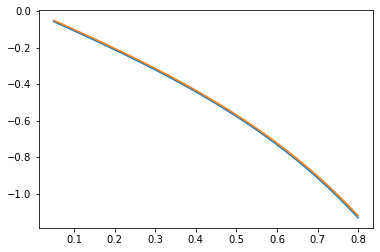

In [17]:
def h_mean(alpha):
    a=np.array([h(g[i], alpha) for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([h_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([1/alpha*(1-np.exp(alpha**2)) for alpha in alphas]))

$$\left\langle \mathrm{e}^{\alpha g} \left(\mathrm{e}^{\alpha g}\right)^\intercal \right\rangle = \mathrm{e}^{\alpha^2} \exp(\alpha^2 \boldsymbol{\Xi}_\mathrm{G})$$

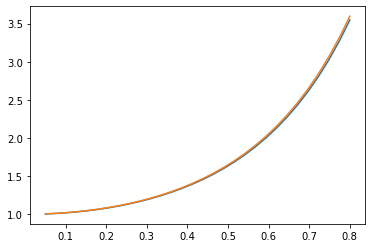

In [18]:
def expag_expag_mean(alpha):
    a=np.array([np.exp(alpha*g[i])*np.exp(alpha*g[i]) for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([expag_expag_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([np.exp(alpha**2)*np.exp(alpha**2) for alpha in alphas]))

$$\left\langle \mathrm{e}^{\alpha g} g^\intercal \right\rangle = \mathrm{e}^{\frac{\alpha^2}{2}} \alpha \boldsymbol{\Xi}_\mathrm{G}$$

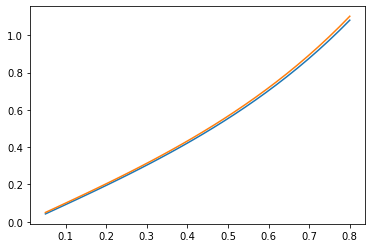

In [19]:
def expag_g_mean(alpha):
    a=np.array([np.exp(alpha*g[i])*g[i] for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([expag_g_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([np.exp(alpha**2/2)*alpha for alpha in alphas]))

$$\textbf{Q} \equiv \left\langle hh^\intercal \right\rangle = \frac{1}{\alpha^2} \left[ \mathrm{e}^{2\alpha^2} \exp(\alpha^2 \boldsymbol{\Xi}_\mathrm{G}) + (1-2\mathrm{e}^{\alpha^2}) \textbf{1}.\textbf{1}^\intercal \right]$$
$$\left\langle h^2 \right\rangle = \frac{1}{\alpha^2} \left(\mathrm{e}^{3\alpha^2} - 2\mathrm{e}^{\alpha^2} + 1 \right)$$

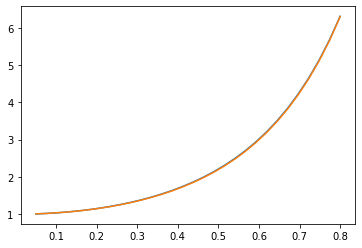

In [20]:
def h2_mean(alpha):
    a=np.array([h(g[i], alpha)**2 for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([h2_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([1/alpha**2*(np.exp(3*alpha**2)-2*np.exp(alpha**2)+1) for alpha in alphas]))

$$\textbf{R} \equiv \left\langle hg^\intercal \right\rangle = \mathrm{e}^{\alpha^2} \boldsymbol{\Xi}_\mathrm{G} $$

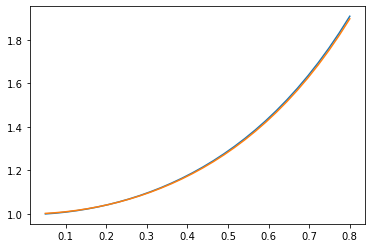

In [21]:
def h_g_mean(alpha):
    a=np.array([h(g[i],alpha)*g[i] for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([h_g_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([np.exp(alpha**2) for alpha in alphas]))

$$\textbf{S} \equiv \left\langle h^2 g^\intercal \right\rangle = \frac{2}{\alpha} \left(\mathrm{e}^{\alpha^2} - \mathrm{e}^{3\alpha^2} \right) \boldsymbol{\Xi}_\mathrm{G}$$

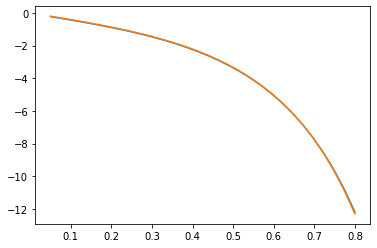

In [22]:
def h2_g_mean(alpha):
    a=np.array([h(g[i],alpha)**2*g[i] for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([h2_g_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([2/alpha*(np.exp(alpha**2) - np.exp(3*alpha**2)) for alpha in alphas]))

$$\left\langle \textbf{K}_{,\alpha} \right\rangle = \frac{2}{\alpha}(\mathrm{e}^{\alpha^2}-1) \boldsymbol{\Xi}_\mathrm{G}$$

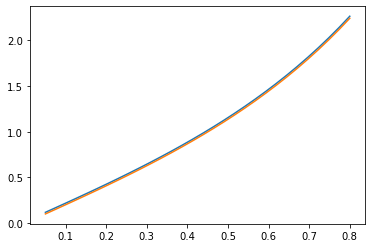

In [23]:
def dK_dalpha_mean(alpha):
    a=np.array([dK_dalpha(g[i],alpha) for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([dK_dalpha_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([2/alpha*(np.exp(alpha**2) - 1) for alpha in alphas]))

$$\left\langle g_{,\alpha} g_{,\alpha}^\intercal \right\rangle = \frac{1}{\alpha^2} \boldsymbol{\Xi}_\mathrm{G} + \frac{1}{\alpha^2} \textbf{Q} + \left[1+ \frac{2}{\alpha^2} \left( 1-\mathrm{e}^{\alpha^2} \right) \right] \textbf{1}.\textbf{1}^\intercal - \frac{2}{\alpha^2} \textbf{R}$$
$$\left\langle g_{,\alpha} g_{,\alpha}^\intercal \right\rangle = \frac{1}{\alpha^2}(1-2\mathrm{e}^{\alpha^2}) \boldsymbol{\Xi}_\mathrm{G} + \frac{1}{\alpha^4}\mathrm{e}^{2\alpha^2} \exp(\alpha^2 \boldsymbol{\Xi}_\mathrm{G}) + \left[\frac{1}{\alpha^4} (1-2\mathrm{e}^{\alpha^2}) + 1 + \frac{2}{\alpha^2} (1-\mathrm{e}^{\alpha^2}) \right] \textbf{1}.\textbf{1}^\intercal$$

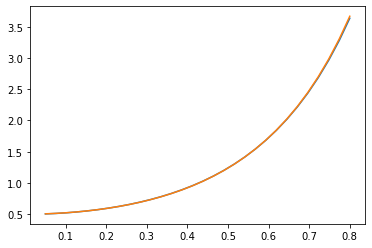

In [24]:
def dg_dalpha2_mean(alpha):
    a=np.array([dg_dalpha(g[i],alpha)**2 for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([dg_dalpha2_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([1/alpha**2*(1-2*np.exp(alpha**2)) +1/alpha**4*np.exp(3*alpha**2) + 1/alpha**4*(1-2*np.exp(alpha**2)) + 1 + 2/alpha**2*(1-np.exp(alpha**2)) for alpha in alphas]))

$$\left\langle g_{,\alpha\alpha} g^\intercal \right\rangle = \frac{2}{\alpha^2} \boldsymbol{\Xi}_\mathrm{G} - \frac{2}{\alpha^2} \textbf{R} - \frac{1}{\alpha}\textbf{S}$$
$$\left\langle g_{,\alpha\alpha} g^\intercal \right\rangle = \frac{2}{\alpha^2} (1 - 2\mathrm{e}^{\alpha^2} + \mathrm{e}^{3\alpha^2}) \boldsymbol{\Xi}_\mathrm{G}$$

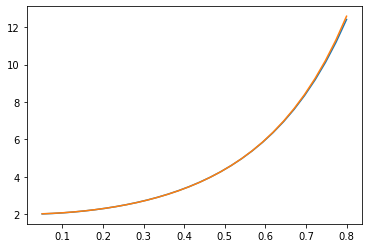

In [25]:
def d2g_dalpha2g_mean(alpha):
    a=np.array([d2g_dalpha2(g[i],alpha)*g[i] for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([d2g_dalpha2g_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([2/alpha**2*(1-2*np.exp(alpha**2)+np.exp(3*alpha**2)) for alpha in alphas]))

$$\left\langle \textbf{K}_{,\alpha\alpha} \right\rangle = \frac{2}{\alpha^2} \left(3 - 6\mathrm{e}^{\alpha^2} + 2\mathrm{e}^{3\alpha^2}\right) \boldsymbol{\Xi}_\mathrm{G} + \frac{2}{\alpha^4} \mathrm{e}^{2\alpha^2} \exp(\alpha^2 \boldsymbol{\Xi}_\mathrm{G}) + 2\left[\frac{1}{\alpha^4} (1-2\mathrm{e}^{\alpha^2}) + 1 + \frac{2}{\alpha^2} (1-\mathrm{e}^{\alpha^2}) \right] \textbf{1}.\textbf{1}^\intercal$$

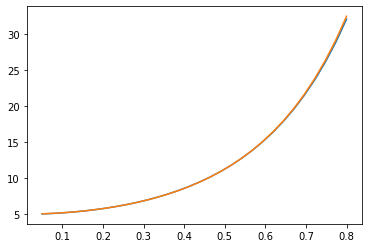

In [26]:
def d2K_dalpha2_mean(alpha):
    a=np.array([d2K_dalpha2(g[i],alpha) for i in range(nfields)])
    a_m=np.array([a[i].mean() for i in range(nfields)])
    return a_m.mean()

plt.plot(alphas, np.array([d2K_dalpha2_mean(alpha) for alpha in alphas]))
plt.plot(alphas, np.array([2/alpha**2*(3-6*np.exp(alpha**2)+2*np.exp(3*alpha**2)) + 2/alpha**4*np.exp(3*alpha**2) + 2* (1/alpha**4*(1-2*np.exp(alpha**2)) + 1 + 2/alpha**2*(1-np.exp(alpha**2))) for alpha in alphas]))

# Fisher forecast for a full field analysis

We define here the $\boldsymbol{\Xi}_{G,\beta}$ and $\exp(\alpha^2\boldsymbol{\Xi}_{G})$ matrices, using
$$\xi_\mathrm{G}(r) = \exp\left(-\frac{1}{4} \frac{r^2}{\beta^2}\right),$$
$$\xi_\mathrm{G,\beta}(r) = \frac{r^2}{2\beta^3} \exp\left(-\frac{1}{4} \frac{r^2}{\beta^2}\right),$$
$$\exp(\alpha^2\xi_\mathrm{G})(r) = \exp\left[ \alpha^2 \exp\left(-\frac{1}{4} \frac{r^2}{\beta^2}\right) \right].$$

In [27]:
def dxiGdbeta(rsq, beta):
    import numpy as np
    
    dxiGdbeta = 1/2*rsq/(beta**3) * np.exp(-0.25*rsq/(beta**2))

    return dxiGdbeta

def expalpha2xiG(rsq, alpha, beta):
    import numpy as np
    
    ea2xiG = np.exp(alpha**2* np.exp(-0.25*rsq/(beta**2)))
    return ea2xiG

Now we define the Fisher matrix:
$$F_{\alpha \alpha} = \frac{N_\mathrm{pix}}{\alpha^2} \left( 2 - 4\mathrm{e}^{\alpha^2} + \mathrm{e}^{3\alpha^2} \right) + \frac{\mathrm{e}^{2\alpha^2}}{\alpha^4} \mathrm{tr} \left[\boldsymbol{\Xi}_\mathrm{G}^{-1} \exp(\alpha^2 \boldsymbol{\Xi}_\mathrm{G}) \right] + \left[\frac{1}{\alpha^4} (1-2\mathrm{e}^{\alpha^2}) + 1 + \frac{2}{\alpha^2} (1-\mathrm{e}^{\alpha^2}) \right] \mathrm{tr} \left( \boldsymbol{\Xi}_\mathrm{G}^{-1} \textbf{1}.\textbf{1}^\intercal \right),$$

In [28]:
def Faa_T1(Lside, alpha):
    T1=Lside**2/alpha**2 * (2-4*np.exp(alpha**2)+np.exp(3*alpha**2))
    return T1

def Faa_T2(Lside, alpha):
    from libLN import LogNormalField
    rsq=LogNormalField.compute_rsquared(Lside)
    xi=LogNormalField.xi_G(rsq, beta)
    ixi=np.linalg.inv(xi)
    ea2xi=expalpha2xiG(rsq, alpha, beta)
    
    T2=np.exp(2*alpha**2)/alpha**4 * np.trace(ixi.dot(ea2xi))
    return T2
    
def Faa_T3(Lside, alpha):
    import numpy as np
    from libLN import LogNormalField
    rsq=LogNormalField.compute_rsquared(Lside)
    xi=LogNormalField.xi_G(rsq, beta)
    ixi=np.linalg.inv(xi)
    oneone=np.ones((Lside*Lside,Lside*Lside))
    
    T3=( 1/alpha**4*(1-2*np.exp(alpha**2)) + 1 + 2/alpha**2*(1-np.exp(alpha**2)) ) * np.trace(ixi.dot(oneone))
    return T3

def Faa(Lside, alpha):
    return Faa_T1(Lside, alpha) + Faa_T2(Lside, alpha) + Faa_T3(Lside, alpha)

$$F_{\alpha \beta} = \frac{1-\mathrm{e}^{\alpha^2}}{\alpha} \mathrm{tr}( \boldsymbol{\Xi}_\mathrm{G}^{-1} \boldsymbol{\Xi}_\mathrm{G,\beta} ),$$

In [29]:
def Fab(Lside, alpha, beta):
    import numpy as np
    from libLN import LogNormalField
    rsq=LogNormalField.compute_rsquared(Lside)
    xi=LogNormalField.xi_G(rsq, beta)
    ixi=np.linalg.inv(xi)
    dxi=dxiGdbeta(rsq, beta)
    return (1-np.exp(alpha**2))/alpha * np.trace(ixi.dot(dxi))

$$F_\mathrm{\beta\beta} = \frac{1}{2} \mathrm{tr}( \boldsymbol{\Xi}_\mathrm{G}^{-1} \boldsymbol{\Xi}_\mathrm{G,\beta} \boldsymbol{\Xi}_\mathrm{G}^{-1} \boldsymbol{\Xi}_\mathrm{G,\beta} ).$$

In [30]:
def Fbb(Lside, beta):
    import numpy as np
    from libLN import LogNormalField
    rsq=LogNormalField.compute_rsquared(Lside)
    xi=LogNormalField.xi_G(rsq, beta)
    ixi=np.linalg.inv(xi)
    dxi=dxiGdbeta(rsq, beta)
    return 1/2. * np.trace(ixi.dot(dxi).dot(ixi).dot(dxi))

In [31]:
def Fisher_matrix(Lside, alpha, beta):
    import numpy as np
    return np.array([[Faa(Lside,alpha),Fab(Lside,alpha,beta)],[Fab(Lside,alpha,beta),Fbb(Lside,beta)]])

We now compare expected and realised errors on $\alpha$ and $\beta$:

In [32]:
run config_10.py

Figures saved at figures/Output20_05_10_80_80_500_80_1_123456
Simulations saved at data/Sims20_05_10_80_80_500_80_1_123456


In [33]:
print("Lside =", Lside)
print("alpha =", alpha)
print("beta =", beta)
print("")

F=Fisher_matrix(Lside, alpha, beta)
print("Fisher matrix:")
print(F)
print("")

print("Expected errors (Cramér-Rao bounds):")
print(marginal_errors(F))
print("")

print("Realised errors:")
f=0
while True:
    try:
        fname=dataout+'_da_'+str(f)+'.npz'
        A=np.load(fname)
        alpha_samples=A['samples'].T[0]
        beta_samples=A['samples'].T[1]
        alpha_std=np.std(alpha_samples)
        beta_std=np.std(beta_samples)
        print(np.array([alpha_std, beta_std]), fname)
        f+=1
    except IOError:
        break

Lside = 20
alpha = 1.0
beta = 0.5

Fisher matrix:
[[11008.1862026   2088.17538292]
 [ 2088.17538292  5815.55875945]]

Expected errors (Cramér-Rao bounds):
[0.00987326 0.01358384]

Realised errors:
[0.01185679 0.01462795] data/Data20_05_10_80_80_500_80_1_123456_da_0.npz
[0.01417958 0.01336487] data/Data20_05_10_80_80_500_80_1_123456_da_1.npz
[0.01185842 0.01383144] data/Data20_05_10_80_80_500_80_1_123456_da_2.npz
[0.01557115 0.0137803 ] data/Data20_05_10_80_80_500_80_1_123456_da_3.npz


In [34]:
run config_02.py

Figures saved at figures/Output20_05_02_80_80_500_80_1_123457
Simulations saved at data/Sims20_05_02_80_80_500_80_1_123457


In [35]:
print("Lside =", Lside)
print("alpha =", alpha)
print("beta =", beta)
print("")

F=Fisher_matrix(Lside, alpha, beta)
print("Fisher matrix:")
print(F)
print("")

print("Expected errors (Cramér-Rao bounds):")
print(marginal_errors(F))
print("")

print("Realised errors:")
f=0
while True:
    try:
        fname=dataout+'_da_'+str(f)+'.npz'
        A=np.load(fname)
        alpha_samples=A['samples'].T[0]
        beta_samples=A['samples'].T[1]
        alpha_std=np.std(alpha_samples)
        beta_std=np.std(beta_samples)
        print(np.array([alpha_std, beta_std]), fname)
        f+=1
    except IOError:
        break

Lside = 20
alpha = 0.2
beta = 0.5

Fisher matrix:
[[ 819.88211143  247.98043201]
 [ 247.98043201 5815.55875945]]

Expected errors (Cramér-Rao bounds):
[0.03515144 0.01319845]

Realised errors:
[0.03169032 0.01296363] data/Data20_05_02_80_80_500_80_1_123457_da_0.npz
[0.0350821  0.01399202] data/Data20_05_02_80_80_500_80_1_123457_da_1.npz
